In [15]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import copy
from tqdm import tqdm

In [16]:
sigm = lambda x: 1/(1+np.exp(-x))

# Neural Stuff

In [17]:
class Layer:


    def __init__(self,NC,NN,ActFun,rate=0.39): # Jugar con la tasa de mutacion

        self.NC = NC
        self.NN = NN
        self.ActFunc = ActFun
        self.rate = rate

        self.W = np.random.uniform( -10.,10.,(self.NC,self.NN) )
        self.b = np.random.uniform( -10.,10.,(1,self.NN) )

    def Activation(self,x):
        z = np.dot(x,self.W) + self.b
        return self.ActFunc( z )[0]

    def Mutate(self):

        #self.W += np.random.normal( loc=0., scale=self.rate, size=(self.NC,self.NN))
        #self.b += np.random.normal( loc=0., scale=self.rate, size=(1,self.NN))

        self.W += np.random.uniform( -self.rate, self.rate, size=(self.NC,self.NN))
        self.b += np.random.uniform( -self.rate, self.rate, size=(1,self.NN))

In [18]:
def GetBrain():
    l0 = Layer(1,5,sigm)
    l1 = Layer(5,1,sigm)
    #l2 = Layer(2,1,sigm)
    Brain = [l0,l1]
    return Brain

# Estructura del Individuo

In [19]:
class Robot:

    def __init__(self, dt, Layers, Id=0):

        self.Id = Id
        self.dt = dt


        self.r = np.random.uniform([0.,0.])
        theta = 0.
        self.v = np.array([1.*np.cos(theta),1.*np.sin(theta)])


        # Capacidad o aptitud del individuo
        self.Fitness = np.inf
        self.Steps = 0

        # Brain
        self.Layers = Layers

    def GetR(self):
        return self.r

    def Evolution(self):
        self.r += self.v*self.dt # Euler integration (Metodos 2)

        # Cada generación regreamos el robot al origin
        # Y volvemos a estimar su fitness
    def Reset(self):
        self.Steps = 0.
        self.r = np.array([0.,0.])
        self.Fitness = np.inf

    # Aca debes definir que es mejorar en tu proceso evolutivo
    def SetFitness(self):
        #self.Fitness = 0. # Esto no hace nada por ahora
        self.Fitness = 1/self.Steps

       # Brain stuff
    def BrainActivation(self,x,threshold=0.7):
        # El umbral (threshold) cerebral es a tu gusto!
        # cercano a 1 es exigente
        # cercano a 0 es sindrome de down

        # Forward pass - la infomación fluye por el modelo hacia adelante
        for i in range(len(self.Layers)):
            if i == 0:
                output = self.Layers[i].Activation(x)
            else:
                output = self.Layers[i].Activation(output)

        self.Activation = np.round(output,4)

        # Cambiamos el vector velocidad
        if self.Activation[0] > threshold:
            self.v = -self.v

            # Deberias penalizar de alguna forma, dado que mucha activación es desgastante!
            # Para cualquier cerebro
            self.Steps *= 0.63

        return self.Activation

    # Aca mutamos (cambiar de parametros) para poder "aprender"
    def Mutate(self):
        for i in range(len(self.Layers)):
            self.Layers[i].Mutate()

    # Devolvemos la red neuronal ya entrenada
    def GetBrain(self):
        return self.Layers

In [20]:
def GetRobots(N):

    Robots = []

    for i in range(N):

        Brain = GetBrain()
        r = Robot(0.15,Brain,Id=i)
        Robots.append(r)

    return Robots

In [21]:
dt = 0.075
t = np.arange(0.,1.,dt)
#Robots = GetRobots(10)

In [22]:
def GetPlot():

    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(1,2,1)
    ax1 = fig.add_subplot(1,2,2)

    ax.set_xlim(-1.,1.)
    ax.set_ylim(-1.,1.)

    return ax,ax1

# Time Evolution

In [23]:
def TimeEvolution(Robots,e,Plot=True):


    for it in range(t.shape[0]):

        if Plot:

            clear_output(wait=True)

            ax,ax1 = GetPlot()
            ax1.set_ylim(0.,1.)

            ax.set_title('t = {:.3f}'.format(t[it]))

        Activation = np.zeros(len(Robots))

        for i,p in enumerate(Robots):
            p.Evolution()

            # Activacion cerebral
            Act = p.BrainActivation(p.GetR()[0])
            Activation[i] = Act
            # Region donde aumentamos los pasos para el fitness
            if p.r[0] <= 1 and p.r[0] >= -1:
              p.Steps += 1
            #else:
              #p.Steps *= 0.7
            #print(p.Steps)
            if Plot and i < 5: # Solo pintamos los primeros 5, por tiempo de computo
                ax.scatter(p.r[0],p.r[1],label='Id: {}, Steps: {:.0f}'.format(p.Id,p.Steps))
                ax.quiver(p.r[0],p.r[1],p.v[0],p.v[1])

        # Pintamos la activaciones de los primeros 5

        if Plot:
            ax1.plot(np.arange(0,len(Robots[:5]),1),Activation[:5],marker='o',color='b',label='Activation')
            ax1.axhline(y=0.7,color='r')

        if Plot:

            ax.legend(loc=0)
            ax1.legend(loc=0)
            plt.show()
            time.sleep(0.001)

# Algoritmo Evolutivo

In [24]:
# Definimos la rutina de entrenamiento
def Genetic(Robots, epochs = 200, Plot = True, Plottime=False):

    # Porcentaje de robots elegidos en cada epoch
    N = int(0.7*len(Robots))

    FitVector = np.array([])


    x = np.linspace(-1,1,20)
    Act = np.zeros_like(x)

    for e in range(int(epochs)):

        # Reiniciamos y mutamos los pesos

        for p in Robots:
            p.Reset()
            p.Mutate()

        # Evolucionamos
        TimeEvolution(Robots,e,Plottime) # Apagar dibujar la evolución para entrenar

        # Actualizamos fitness de cada robot
        for i,p in enumerate(Robots):
            p.SetFitness()

        # Aca va toda la rutina de ordenar los bots del más apto al menos apto
        scores = [ (p.Fitness,p) for p in Robots ]
        scores.sort(  key = lambda x: x[0], reverse = False  )
        print(scores[0])
        Temp = [r[1] for i,r in enumerate(scores) if i < N]
        # Guardamos el mejor fitness y el mejor robot
        best_fitness = scores[0][0]
        best_bot = scores[0][1] #Esto no es asi, deben ver como se elige al mejor

        # Copiado profundo
        for i,r in enumerate(Robots):
            j = i%N
            Robots[i] = copy.deepcopy(Temp[j])

        FitVector = np.append(FitVector,best_fitness)

        for i in range(len(x)):
            Act[i] = best_bot.BrainActivation(x[i])

        clear_output(wait=True)

        print('Epoch:', e)

        # Last fitness
        print('Last Fitness:', FitVector[-1])


        if Plot:

            ax,ax1 = GetPlot()
            ax.plot(x,Act,color='k')
            ax.set_ylim(0.,1)
            ax.axhline(y=0.75,ls='--',color='r',label='Threshold')

            ax1.set_title('Fitness')
            ax1.plot(FitVector)

            ax.legend(loc=0)

            plt.show()

            time.sleep(0.01)



    return best_bot, FitVector

Epoch: 199
Last Fitness: 0.07987220447284345


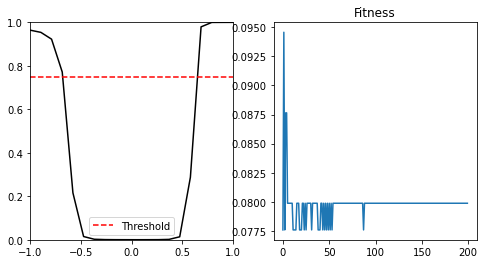

In [25]:
Robots = GetRobots(200)
Best, FitVector = Genetic(Robots,Plot=True)#,Plottime=True) # Apagar Plottime para el entrenamiento

Pesos de los Layers

In [26]:
Best.Layers[0].W , Best.Layers[0].b

(array([[13.36753368,  9.28075137, -5.26642116,  3.43539355, 13.54552216]]),
 array([[ 7.48456408, -4.77400502, -2.66240447,  7.91253968, -9.28956507]]))

In [27]:
Best.Layers[1].W , Best.Layers[1].b

(array([[-6.86492547],
        [ 7.86693881],
        [ 4.94396696],
        [ 6.56885703],
        [10.93947259]]),
 array([[-7.78748975]]))

Prueba 10seg

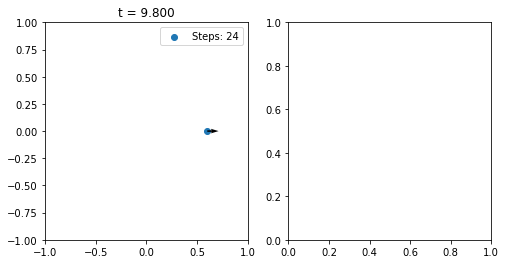

In [28]:
Plot = True
t = np.arange(0.,10.,0.2)

for it in range(t.shape[0]):

        if Plot:

            clear_output(wait=True)

            ax,ax1 = GetPlot()
            ax1.set_ylim(0.,1.)

            ax.set_title('t = {:.3f}'.format(t[it]))

            Best.Evolution()

            # Activacion cerebral
            Best.BrainActivation(Best.GetR()[0])
            # Region donde aumentamos los pasos para el fitness
            if Best.r[0] <= 1 and Best.r[0] >= -1:
              Best.Steps += 1

            if Plot: # Solo pintamos los primeros 5, por tiempo de computo
                ax.scatter(Best.r[0],Best.r[1],label='Steps: {:.0f}'.format(Best.Steps))
                ax.quiver(Best.r[0],Best.r[1],Best.v[0],Best.v[1])

        if Plot:

            ax.legend(loc=0)
            plt.show()
            time.sleep(0.001)